# Create GEANT4 Input HEPEVT Files for Cosmic Muons - Short Version

This script is adapted from https://github.com/yuntsebaryon/SimpleCosmics/blob/main/Cosmics/CreateGEANT4InputCosmicsShort.ipynb,
but filling the results into a hepevt format for edep-sim, the GEANT4 wrapper.

The pre-requisite is the cosmic flux file, `/Users/yuntse/data/coherent/preLArTPC/cosmic/CosmicFlux.npy`, which can be generated by the script https://github.com/yuntsebaryon/SimpleCosmics/blob/main/Cosmics/GenCosmicFlux.ipynb but takes long time.

Also consider to generate the cosmic muons from a 6$\times$6 m$^2$ area (instead of 10$\times$10 m$^2$ in the 2024 study)

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
# Load the cosmic flux file
cosmics = np.load('/Users/yuntse/data/coherent/preLArTPC/cosmic/CosmicFlux.npy')
len(cosmics)

6

In [3]:
Lmax = len(cosmics[0])
Lmax

10000000

## Determine the fractions from the six phase space (p, costh) regions

In [4]:
# Analytical cosmic ray flux from the paper
def dI_dpdcosth(costh, p):
    return 18/(p*costh+145)* (1./np.power(p+2.7/costh, 2.7))* (p+5)/(p+5/costh)

In [5]:
# The fraction of the six (p, costh) areas
pmins = np.array([1., 1., 2., 2., 4., 10.])
pmaxs = np.array([2., 2., 4., 4., 10., 10000.])
costhmins = np.array([0., 0.5, 0., 0.5, 0., 0.])
costhmaxs = np.array([0.5, 1., 0.5, 1., 1., 1.])
Is = np.array([
              integrate.dblquad(dI_dpdcosth, pmin, pmax, costhmin, costhmax)
              for pmin, pmax, costhmin, costhmax in zip(pmins, pmaxs, costhmins, costhmaxs) ])
Is

array([[4.64644323e-05, 1.18104498e-14],
       [6.57350877e-04, 9.54998544e-18],
       [6.62890781e-05, 2.49271358e-14],
       [6.63691325e-04, 7.36845390e-18],
       [7.13559963e-04, 2.99131045e-11],
       [4.79661416e-04, 3.34803625e-09]])

In [6]:
Imax = Is[:,0].max()
L = np.round(Is[:,0]*Lmax/Imax)
Lrounded = L.astype(int)
L, Lrounded

(array([  651164.,  9212272.,   928991.,  9301129., 10000000.,  6722090.]),
 array([  651164,  9212272,   928991,  9301129, 10000000,  6722090]))

In [7]:
cosmics[0], cosmics[0][0:3]

(array([[1.69026559, 0.47500469],
        [1.62594644, 0.47681492],
        [1.63929539, 0.4734408 ],
        ...,
        [1.06612328, 0.4722691 ],
        [1.18713756, 0.3521335 ],
        [1.03874213, 0.39006242]]),
 array([[1.69026559, 0.47500469],
        [1.62594644, 0.47681492],
        [1.63929539, 0.4734408 ]]))

In [8]:
cosmicsAll = np.concatenate([ cosmics[i][0:Lrounded[i]] for i in range(6) ])
nAllCosmics = len(cosmicsAll)
len(cosmicsAll), Lrounded.sum()

(36815646, 36815646)

## How many events and how many cosmic rays per event

In [9]:
nEvents = 20000000

In [10]:
# Cosmic ray measured by MicroBooNE: 113Hz/m^2
CR = 113
# Event length: 200µs
drift_time = 2*1e-4
# Dimension of the area to be simulated [m]
Larea = 6.
CREvent = CR*(Larea**2)*drift_time
CREvent

0.8136

In [11]:
1/CR/(Larea**2)

0.0002458210422812193

In [12]:
nCRperEvent = 1

In [13]:
allCosmicsIndex = np.arange(len(cosmicsAll)).astype(int)
allCosmicsIndex[-1], len(allCosmicsIndex)

(36815645, 36815646)

## Choose the index for the momentum and the polar angle of each cosmic ray

In [14]:
allSelectedCosmicsIndex = []

In [15]:
# Perform the random selection for nEvents iterations
for iEvt in range(nEvents):
    # Randomly choose three unique objects
    selectedCosmicsIndex = np.random.randint(low = 0, high = nAllCosmics, size = nCRperEvent)
    allSelectedCosmicsIndex.append( selectedCosmicsIndex )

## Generate the azimuthal direction of the cosmic ray

In [16]:
rng = np.random.default_rng()
CosmicsPhi = rng.uniform(0, 2*np.pi, nEvents)
CosmicsPhi

array([6.07382684, 2.1927987 , 0.85464135, ..., 2.71752473, 4.78587648,
       3.19581281])

## Save in a npy file

In [17]:
cosmicL = []

In [18]:
for iEvt in range(nEvents):    
    for iCosmic in range(nCRperEvent):
        
        p, costh = cosmicsAll[allSelectedCosmicsIndex[iEvt][iCosmic]]
        phi = CosmicsPhi[iEvt]
        cosmicL.append( [p, costh, phi] )

In [19]:
vcosmic = np.array( cosmicL )

In [20]:
vcosmic[:,1]

array([0.62958547, 0.69741975, 0.89234413, ..., 0.92142099, 0.4675961 ,
       0.81109548])

In [21]:
with open('Cosmic4Vector.npy', 'wb') as f:
    np.save(f, vcosmic)

## Validation

In [22]:
outHist = np.histogram2d(vcosmic[:,0], vcosmic[:,1], bins = [18, 8], range = [[1., 10.], [0.2, 1]])

In [23]:
costh, p = np.meshgrid(outHist[2][0:-1], outHist[1][0:-1])

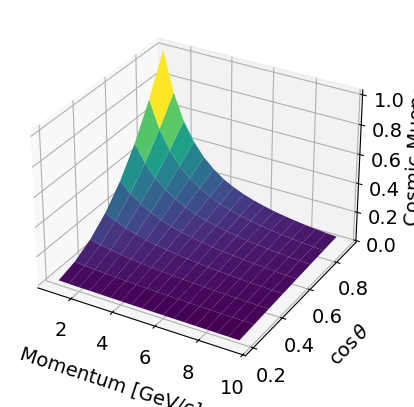

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
 
ax.plot_surface( p, costh, outHist[0], cmap = 'viridis')

ax.set_xlabel( 'Momentum [GeV/c]', fontsize = 14, labelpad = 10 )
ax.set_ylabel( r'$\cos\theta$', fontsize = 14, labelpad = 10 )
ax.set_zlabel( r'Cosmic Muon', fontsize = 14)
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.tick_params(axis = 'z', labelsize = 14)

In [25]:
# Find the center point of each bin 
cosRefBin = np.arange(0.25, 1.05, 0.1)
pRefBin = np.arange(1.25, 10.25, 0.5)
cosRef, pRef = np.meshgrid(cosRefBin, pRefBin)
# cosRef, pRef
# dI_dpdcosth(cosRef, pRef)
cosRef.size, len(pRef)

(144, 18)

In [26]:
I = integrate.dblquad(dI_dpdcosth, 1., 10., 0.2, 1.)
norm = outHist[0].sum()*9*0.8/I[0]/(18*8)
outHist[0].sum()

16297090.0

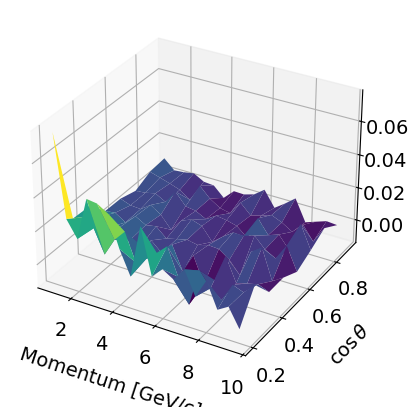

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

formula = dI_dpdcosth(cosRef, pRef)*norm
diff = (outHist[0] - formula)/formula
ax.plot_surface( p, costh, diff, cmap = 'viridis')

ax.set_xlabel( 'Momentum [GeV/c]', fontsize = 14, labelpad = 10 )
ax.set_ylabel( r'$\cos\theta$', fontsize = 14, labelpad = 10 )
# ax.set_zlabel( r'Difference Raio', fontsize = 14)
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.tick_params(axis = 'z', labelsize = 14)

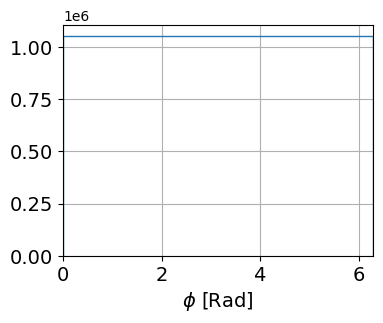

In [28]:
fig, ax = plt.subplots( figsize = (4, 3) )  

ax.hist(vcosmic[:,2], bins = np.linspace(0, 2*np.pi, 20), histtype = 'step')
ax.set_xlabel( r'$\phi$ [Rad]', fontsize = 14 )
# ax.set_ylabel( r'Cosmic muon flux [Hz]', fontsize = 16 )
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.set_xlim( [0, 2*np.pi])
# ax.set_ylim( [0, 1.1])

ax.grid(":")

In [29]:
len(vcosmic[:,2])

20000000

## Generate the location and time: xyzt

Currently only support one cosmic ray in each event

In [30]:
rng = np.random.default_rng()
# location and time in [cm, ns]
# currently only support one cosmic ray in each event
zloc = 700.
xyzt = np.array([ [ x, y, z, t ] 
                      for x, y, z, t in zip(rng.uniform(-Larea*100./2., Larea*100./2., nEvents), 
                                            rng.uniform(-Larea*100./2., Larea*100./2., nEvents),
                                            np.full(nEvents, 700.),
                                            rng.uniform(0, 2.e5, nEvents)) ])
xyzt

array([[ 1.74845052e+02,  1.97646288e+02,  7.00000000e+02,
         1.32701658e+05],
       [ 3.37143388e+01,  2.69506378e+02,  7.00000000e+02,
         1.41016513e+04],
       [ 2.22731380e+02, -1.87437956e+01,  7.00000000e+02,
         4.03545477e+04],
       ...,
       [-1.42345020e+02, -2.76444743e+02,  7.00000000e+02,
         1.39605865e+05],
       [-2.63597732e+02,  9.24903940e+01,  7.00000000e+02,
         4.03361880e+04],
       [ 5.96983446e+01,  2.41991323e+02,  7.00000000e+02,
         1.25752325e+05]])

(-10.0, 210.0)

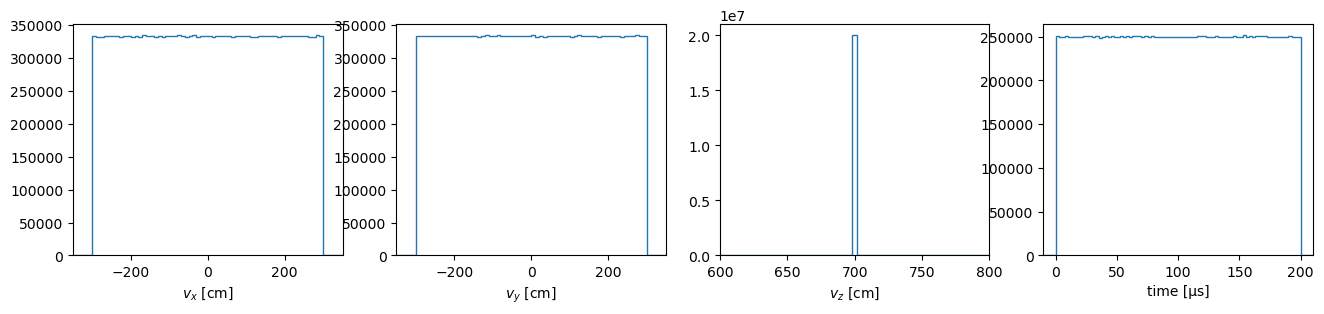

In [31]:
fig, ax = plt.subplots(1, 4, figsize = (16, 3) )

ax[0].hist(xyzt[:,0], bins = np.linspace(-350, 350, 71), histtype = 'step')
ax[0].set_xlabel(r'$v_x$ [cm]')
ax[0].set_xlim( [-350, 350] )

ax[1].hist(xyzt[:,1], bins = np.linspace(-350, 350, 71), histtype = 'step')
ax[1].set_xlabel(r'$v_y$ [cm]')
ax[1].set_xlim( [-350, 350] )

ax[2].hist(xyzt[:,2], bins = np.linspace(600, 800, 50), histtype = 'step')
ax[2].set_xlabel(r'$v_z$ [cm]')
ax[2].set_xlim( [600, 800] )

ax[3].hist(xyzt[:,3]/1000, bins = np.linspace( -10, 210, 89), histtype = 'step')
ax[3].set_xlabel('time [µs]')
ax[3].set_xlim( [-10, 210])

## Fill in a hepevt file

The output format is compatible with the HEPEVT reader of edep-sim:
https://github.com/ClarkMcGrew/edep-sim/blob/master/src/kinem/EDepSimHEPEVTKinematicsGenerator.cc

In [32]:
import os
outdir = '/Users/yuntse/data/coherent/SNeNDSens/Cosmics/hepevt'

if os.path.exists(outdir):
    raise FileExistsError(f"Directory '{outdir}' already exists!")
else:
    os.makedirs(outdir)

nEventPerFile = 5000
nFiles = int(nEvents/nEventPerFile)

In [33]:
# muon's constant
muPdg = 13
# unit: GeV
muMass = 0.105658
nParticlePerVtx = 1

In [34]:
# For each file
for iFile in range(nFiles):
    outfile = f'{outdir}/CosmicFlux_{iFile:04d}.hepevt'

    with open(outfile, 'w') as f:
        for iEvtPerFile in range(nEventPerFile):
            iEvt = iFile*nEventPerFile + iEvtPerFile

            # Each cosmic ray
            for iCosmic in range(nCRperEvent):
                # Evt id, vertex id, number of particles from that vertex 
                f.write( f'{iEvt} {iCosmic} {nParticlePerVtx}\n')

                # ISTHEP IDHEP JMOHEP1 JMOHEP2 JDAHEP1 JDAHEP2 PHEP1 PHEP2 PHEP3 PHEP4 PHEP5 VHEP1 VHEP2 VHEP3 VHEP4
                # final-state particle
                ISTHEP = 1
                IDHEP = muPdg
                # The JMOHEP1, JMOHEP2, JDAHEP1, and JDAHEP2 entries record the indices (between 1 and NHEP, inclusive) 
                # of particles in the event record that correspond to the first mother, second mother, first daughter, 
                # and last daughter of the current particle, respectively. 
                JMOHEP1 = 0
                JMOHEP2 = 0
                JDAHEP1 = 0
                JDAHEP2 = 0

                p, costh = cosmicsAll[allSelectedCosmicsIndex[iEvt][iCosmic]]
                phi = CosmicsPhi[iEvt]
                sinth = np.sqrt(1 - costh**2)
        
                E = np.sqrt( p**2 + muMass**2 )
                px = p*sinth*np.cos(phi)
                py = p*sinth*np.sin(phi)
                pz = -p*costh

                PHEP1 = px
                PHEP2 = py
                PHEP3 = pz
                PHEP4 = E
                PHEP5 = muMass
                VHEP1 = xyzt[iEvt][0]
                VHEP2 = xyzt[iEvt][1]
                VHEP3 = xyzt[iEvt][2]
                VHEP4 = xyzt[iEvt][3]
                f.write( f'{ISTHEP} {IDHEP} {JMOHEP1} {JMOHEP2} {JDAHEP1} {JDAHEP2} {PHEP1} {PHEP2} {PHEP3} {PHEP4} {PHEP5} {VHEP1} {VHEP2} {VHEP3} {VHEP4}\n')

## Validation

In [35]:
# Read in the hepevt file
events = []

with open(outfile) as f:
    while True:
        line = f.readline()
        if not line:
            break  # End of file

        parts = line.strip().split()
        if len(parts) < 3:
            continue

        try:
            n_particles = int(parts[2])
        except ValueError:
            continue  # Skip malformed lines

        event = []
        for _ in range(n_particles):
            particle_line = f.readline()
            data = particle_line.strip().split()
            if len(data) >= 15:
                particle = {
                    "ISTHEP": int(data[0]),
                    "IDHEP": int(data[1]),
                    "JMOHEP1": int(data[2]),
                    "JMOHEP2": int(data[3]),
                    "JDAHEP1": int(data[4]),
                    "JDAHEP2": int(data[5]),
                    "PHEP1": float(data[6]),
                    "PHEP2": float(data[7]),
                    "PHEP3": float(data[8]),
                    "PHEP4": float(data[9]),
                    "PHEP5": float(data[10]),
                    "VHEP1": float(data[11]),
                    "VHEP2": float(data[12]),
                    "VHEP3": float(data[13]),
                    "VHEP4": float(data[14]),
                }
                event.append(particle)
        events.append(event)

In [36]:
px = np.array([ particle['PHEP1'] for event in events for particle in event ])
py = np.array([ particle['PHEP2'] for event in events for particle in event ])
pz = np.array([ particle['PHEP3'] for event in events for particle in event ])
e = np.array([ particle['PHEP4'] for event in events for particle in event ])
m = np.array([ particle['PHEP5'] for event in events for particle in event ])
x = np.array([ particle['VHEP1'] for event in events for particle in event ])
y = np.array([ particle['VHEP2'] for event in events for particle in event ])
z = np.array([ particle['VHEP3'] for event in events for particle in event ])
t = np.array([ particle['VHEP4'] for event in events for particle in event ])

In [37]:
p = np.sqrt( px**2 + py**2 + pz**2 )
costh = -pz/p
phi = np.arctan( py/px )

In [38]:
outHistHepevt = np.histogram2d(p, costh, bins = [18, 8], range = [[1., 10.], [0.2, 1]])

In [39]:
costhH, pH = np.meshgrid(outHistHepevt[2][0:-1], outHistHepevt[1][0:-1])

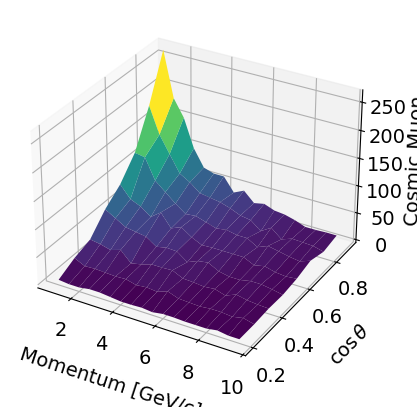

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
 
ax.plot_surface( pH, costhH, outHistHepevt[0], cmap = 'viridis')

ax.set_xlabel( 'Momentum [GeV/c]', fontsize = 14, labelpad = 10 )
ax.set_ylabel( r'$\cos\theta$', fontsize = 14, labelpad = 10 )
ax.set_zlabel( r'Cosmic Muon', fontsize = 14)
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.tick_params(axis = 'z', labelsize = 14)

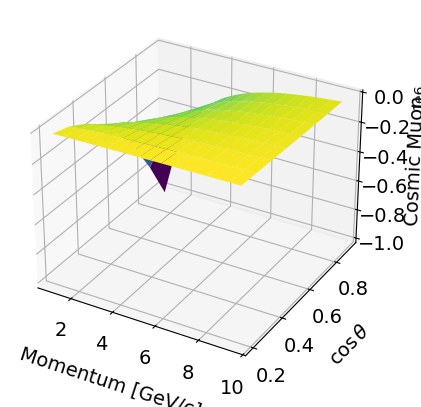

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
 
ax.plot_surface( pH, costhH, outHistHepevt[0]-outHist[0], cmap = 'viridis')

ax.set_xlabel( 'Momentum [GeV/c]', fontsize = 14, labelpad = 10 )
ax.set_ylabel( r'$\cos\theta$', fontsize = 14, labelpad = 10 )
ax.set_zlabel( r'Cosmic Muon', fontsize = 14)
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.tick_params(axis = 'z', labelsize = 14)

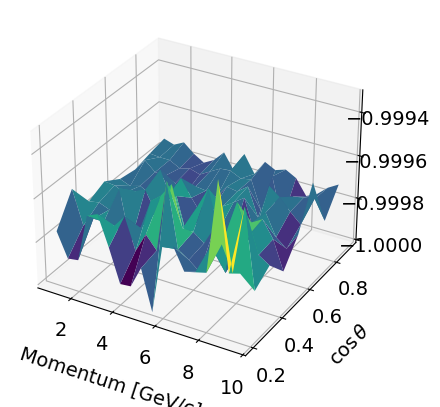

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

formula = dI_dpdcosth(cosRef, pRef)*norm
diff = (outHistHepevt[0] - formula)/formula
ax.plot_surface( pH, costhH, diff, cmap = 'viridis')

ax.set_xlabel( 'Momentum [GeV/c]', fontsize = 14, labelpad = 10 )
ax.set_ylabel( r'$\cos\theta$', fontsize = 14, labelpad = 10 )
# ax.set_zlabel( r'Difference Raio', fontsize = 14)
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.tick_params(axis = 'z', labelsize = 14)

In [52]:
outHist[0].sum()

16294437.0

In [53]:
Is[-1][0]/Is[:,0].sum()

0.1825878552517158

In [54]:
(3000-outHist[0].sum())/3000

-5430.479